In [1]:
import numpy as np
import matplotlib.pyplot as plt 

fontsize=16
z_lens = np.array([0.1,0.3,0.5,0.7])
z_sour = np.array([0.4,0.6,0.8,1.0])

In [2]:
# the rescaled 2-point correlation functions (2PCF)
# d1: galaxy-galaxy lensing 
# d2: galaxy-CMB lensing 
# d1_cov: the covariance matrix of galaxy-galaxy lensing 2PCF
# d2_cov: the covariance matrix of galaxy-CMB lensing 2PCF

d1 = np.load('ratio_data/d1_planck.npy')
d2 = np.load('ratio_data/d2_planck.npy')
d1_cov = np.load('ratio_data/d1_cov_planck.npy')
d2_cov = np.load('ratio_data/d2_cov_planck.npy')

SNR= [4.9767441860465125, 4.9940476190476195, 4.87689713322091, 8.000000000000002, 8.018518518518519, 8.367403314917125]
SNR_TOTAL= 16.486439804548215


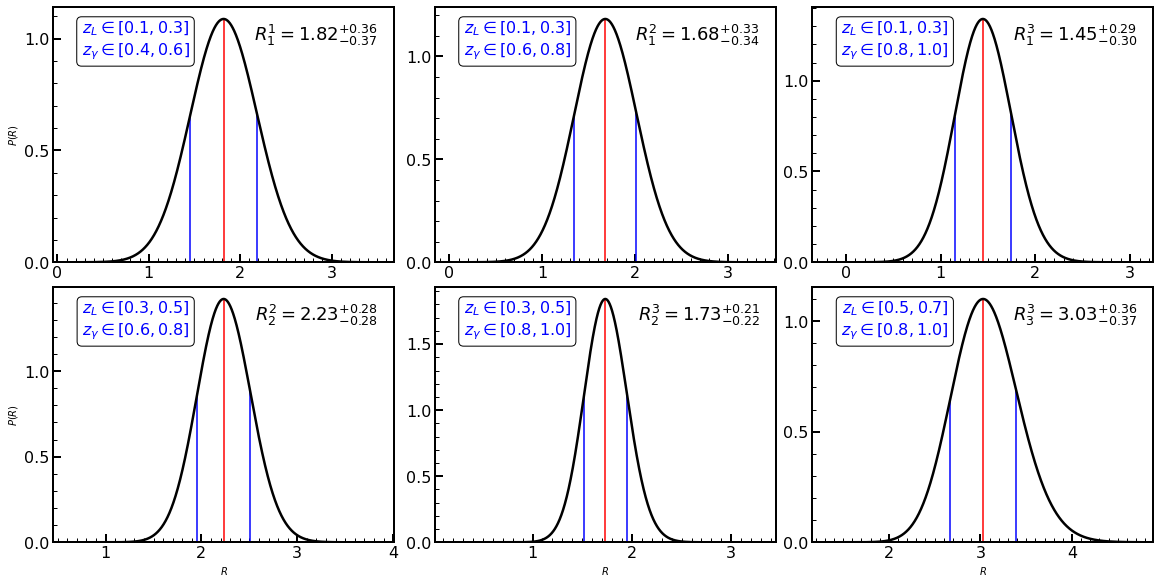

In [3]:
a=4  # scale cut: theta_min
b=10  # scale cut: theta_max
deltaR=0.001
R = np.arange(0.001,5,deltaR)
NR = len(R)

def Matrix3(M1,M2,M3):
    return np.dot(np.dot(M1,M2),M3)

def prob_R(d1,d2,cov1,cov2,R):
    from numpy.linalg import inv
    n = d1.shape[0]
    a1 = np.identity(n)
    a2 = a1 * R
    q1 = Matrix3(a1.T, inv(cov1), a1)
    q2 = Matrix3(a2.T, inv(cov2), a2)
    q = q1 + q2
    d1 = d1.reshape(1,n)
    d2 = d2.reshape(1,n)
    x1 = Matrix3(a1.T, inv(cov1), d1.T)
    x2 = Matrix3(a2.T, inv(cov2), d2.T)
    x = x1 + x2
    return 0.5 * Matrix3(x.T, inv(q), x), (np.linalg.det(q))**(-0.5)

def pdf(i):
    Exp_index=[]
    DetQ=[]
    for rr in range(NR):
        exp_index, detQ = prob_R(d1=d2[i][a:b],d2=d1[i][a:b],cov1=d2_cov[i][a:b,a:b],cov2=d1_cov[i][a:b,a:b],R=R[rr])
        Exp_index.append(exp_index)
        DetQ.append(detQ)
    Exp_index = np.array(Exp_index).reshape(NR)
    index_max = max(Exp_index)

    PROB = np.exp(Exp_index - index_max) * DetQ
    y = PROB/PROB.max() / R  # Jefferys 1/R prior
    area = deltaR * np.sum(y)
    y_norm = y / area 
    max_index = np.argmax(y_norm)
    R_mean = R[max_index]
    return max_index, R_mean, y_norm


def pdf_1sigma(max_index, R_mean, y_norm):
    f = np.ones(max_index-0)*100
    for x in range(0,max_index):
        f[x] = abs(0.34 / deltaR - np.sum(y_norm[x:max_index]))
    x1 = np.argmin(f)
    v = np.ones(NR - max_index)*100
    for u in range(max_index,NR):
        v[u-max_index] = abs(0.34 / deltaR - np.sum(y_norm[max_index:u]))
    x2 = max_index + np.argmin(v)

    delta_x1 = R[max_index] - R[x1]
    delta_x2 = R[x2] - R[max_index]
    return x1, x2, delta_x1, delta_x2


def plot_pdf():
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    fig,axs = plt.subplots(nrows=2, ncols=3,constrained_layout=True,figsize=(16,8),)
    R_MEAN = []; DELTA_x1 = []; DELTA_x2 = []; SNR = []
    R_MEAN_new = []; DELTA_x1_new = []; DELTA_x2_new = []; SNR_new = []
    DELTA_x11_new = []; DELTA_x22_new = [];
    for ax, i in zip(axs.flat, range(6)):
        z_l = np.array([0,0,0,1,1,2])[i]
        z_s = np.array([0,1,2,1,2,2])[i]
        
        max_index, R_mean, y_norm = pdf(i)
        x1, x2, delta_x1, delta_x2 = pdf_1sigma(max_index, R_mean, y_norm)
        R_MEAN.append(R_mean)
        DELTA_x1.append(delta_x1)
        DELTA_x2.append(delta_x2)
        snr = R_mean / (delta_x1+delta_x2) * 2
        SNR.append(snr)
        
        ax.plot(R,y_norm,'k', lw=2.5, label='$R_%s^%s = %1.2f^{+%.2f}_{-%.2f}$'%(z_l+1,z_s+1,R_mean, delta_x2, delta_x1))
        ax.vlines(R_mean, 0, y_norm[max_index], color='r',ls='-')
        ax.vlines(R[x1], 0, y_norm[x1], color='b',ls='-')
        ax.vlines(R[x2], 0, y_norm[x2], color='b',ls='-')
        
        ax.set_ylim(0)
        ax.set_xlim(R[x1]-1.5, R[x2]+1.5)
        ax.tick_params(labelsize=fontsize)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.tick_params(axis='x',which='major',size=8,width=2)
        ax.tick_params(axis='y',which='major',size=8,width=2)
        ax.tick_params(axis='x',which='minor',size=4,width=1)
        ax.tick_params(axis='y',which='minor',size=4,width=1)
        ymajorLocator = MultipleLocator(0.5) 
        ax.yaxis.set_major_locator(ymajorLocator)
        yminorLocator = MultipleLocator(0.1) 
        ax.yaxis.set_minor_locator(yminorLocator)
        xmajorLocator = MultipleLocator(1) 
        ax.xaxis.set_major_locator(xmajorLocator)
        xminorLocator = MultipleLocator(0.1) 
        ax.xaxis.set_minor_locator(xminorLocator)
        ax.annotate('$z_L\in[%s,%s]$\n$z_\gamma\in[%s,%s]$'%(z_lens[z_l], z_lens[z_l+1], z_sour[z_s],z_sour[z_s+1]), 
                    xy=(1, 1),xytext=(0.4,0.95), xycoords='axes fraction',
                    size=16, ha='right', va='top', color='b',
                    bbox=dict(boxstyle='round', fc='w'),
                    )
        leg = ax.legend(loc=1,fontsize=18,handlelength=0, handletextpad=0, frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
    axs[1,0].set_xlabel('$R$')
    axs[1,1].set_xlabel('$R$')
    axs[1,2].set_xlabel('$R$')
    axs[0,0].set_ylabel('$P(R)$')
    axs[1,0].set_ylabel('$P(R)$')

    print ('SNR=',SNR)
    SNR_TOTAL = np.sqrt(np.sum(np.array(SNR)**2))
    print ('SNR_TOTAL=',SNR_TOTAL)

plot_pdf()